 Importing Libraries and Dependencies

In [19]:
# import the necessary packages
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

Initialising model arguments and constants

In [20]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=224, type=int, help='Dimensions of the input image')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing CXR images')
parser.add_argument('--epochs', default=30, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.01, type=float, help='Learning rate')
parser.add_argument('--momentum', default=0.5, type=float, help='Momentum')
parser.add_argument("-p", "--plot", type=str, default="plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="model_plot.png", help="Path to save model's plot")
parser.add_argument("-m", "--model", type=str, default="covid19.model", help="Path to save trained model")
args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS=args.epochs
BS = args.bs
LR = args.lr
MOMENTUM = args.momentum

Namespace(bs=8, datadir='data', epochs=30, input_size=480, lr=0.01, model='covid19.model', momentum=0.5, plot='plot.png', testfile='test_split.txt', trainfile='train_split.txt')


Loading and preprocessing the dataset

In [3]:
with open(args.train_file) as f:
    train_files = f.readlines()
with open(args.test_file) as f:
    test_files = f.readlines()

def load_data(data_dir, data_files, folder):
    data, labels = [] , []
    # Looping all entries in train/test metadata file
    for data_file in data_files:
        # Extracting class labels
        label = data_file.split()[-2]
        # Loading images and resizing for model input
        image = cv2.imread(os.path.join(data_dir, folder, data_file.split()[1]))
        #TODO: Change and check model performance
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (args.input_size, args.input_size))
        # Adding to data and label lists
        data.append(image)
        labels.append(label)
    # Converting the loaded images to numpy arrays for model input and scaling
    # pixel intensities between [0,1]
    data = np.array(data) / 255.0
    labels = np.array(labels)
    return data, labels

# Calling load_data method to generate training and testing datasets
train_data, train_labels = load_data(args.data_dir, train_files, "train")
test_data, test_labels = load_data(args.data_dir, test_files, "test")

# Converting labels from word format to one-hot encoding
lb = LabelBinarizer()
train_labels = lb.fit_transform(train_labels)
test_labels = lb.fit_transform(test_labels)

In [7]:
# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [23]:
# Saving a plot of the model
plot_model(model, to_file=args.model_plot.png, show_shapes=True, show_layer_names=True)

# Initialising data augmentation object to improve the dataset
train_aug = ImageDataGenerator(rotation_range=15,fill_mode="nearest")

# Function to change learning rate as per epoch
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 27:
        lr *= 1e-3
    elif epoch > 24:
        lr *= 1e-2
    elif epoch > 15:
        lr *= 1e-1
    return lr

lr_scheduler = LearningRateScheduler(lr_schedule)

# Reducing learning rate by a factor if there is no improvement
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               patience=3,
                               min_lr=0.5e-6)

callbacks = [lr_reducer, lr_scheduler]

# Compiling model
print("[INFO] Compiling model")
opt = SGD(lr=LR, momentum=MOMENTUM, decay=LR/EPOCHS, nesterov=True)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=['accuracy'])

# Calculating class weights since COVID-19 data is very less
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels),
                                                 train_labels)
print("class weights are " + class_weights)
# Training model
print("[INFO] Training model")
H = model.fit_generator(
	train_aug.flow(train_data, train_labels, batch_size=BS),
	steps_per_epoch=len(train_data) // BS,
	validation_data=(test_data, test_labels),
	validation_steps=len(test_data) // BS,
	epochs=EPOCHS,
    class_weight=class_weights)

[INFO] Compiling Model
[INFO] training head...
  ...
    to  
  ['...']
Train for 1740 steps, validate on 1579 samples
Epoch 1/30
1740/1740 [==============================] - 130s 75ms/step - loss: 0.5594 - accuracy: 0.7708 - val_loss: 0.4929 - val_accuracy: 0.8217

KeyboardInterrupt: 

In [9]:
# Evaluating model on testing data
print("[INFO] Evaluating model on testing data")
pred = model.predict(test_data, batch_size=BS)

# Generating predictions on test data
pred = np.argmax(pred, axis=1)

# Printing classification report
print(classification_report(test_labels.argmax(axis=1), pred,
	target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

    COVID-19       1.00      0.02      0.04       100
      normal       0.85      0.95      0.90       885
   pneumonia       0.82      0.81      0.81       594

   micro avg       0.84      0.84      0.84      1579
   macro avg       0.89      0.59      0.58      1579
weighted avg       0.85      0.84      0.81      1579



In [10]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(test_labels.argmax(axis=1), pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2,2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1] + cm[1, 2])

# Printing found values
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[  2  33  65]
 [  0 842  43]
 [  0 113 481]]
acc: 0.8391
sensitivity: 0.0571
specificity: 1.0000


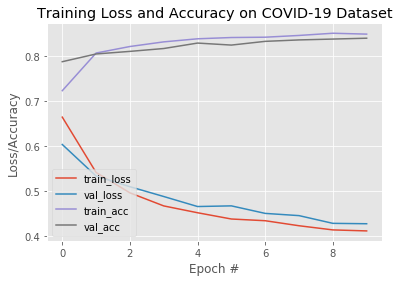

In [11]:
# Plotting training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
args.plot = "plot_vgg16_sgd.png"
plt.savefig(args.plot)

In [13]:
# Serialising model to disk
print("[INFO] Saving COVID-19 VGG model")
args.model = "COVID_VGG16_SGD.model"
model.save(args.model, save_format="h5")



[INFO] saving COVID-19 detector model...
